In [1]:
# Importacion de librerias
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# Función para obtener una lista de ROIs en una matriz NxM centrada en el frame con cuadrados equiespaciados
def obtener_rois_matriz(frame, N, M, porcentaje_area=0.10):
    frame_height, frame_width = frame.shape[:2]
    area_total = frame_width * frame_height

    # Si N=1 y M=1 y el porcentaje es 100%, el rectángulo ocupa todo el frame
    if N == 1 and M == 1 and porcentaje_area == 1.0:
        roi = frame[0:frame_height, 0:frame_width]
        return [roi], frame_width, frame_height, 0, 0, 0, 0

    # Calcula el área total deseada para los cuadrados (el porcentaje del área del frame)
    area_roi_total = area_total * porcentaje_area

    # Calcula el área de cada cuadrado
    area_cada_cuadrado = area_roi_total / (N * M)

    # Calcula el tamaño del lado de los cuadrados
    lado_cuadrado = int(np.sqrt(area_cada_cuadrado))

    # El espacio entre los cuadrados también será igual al lado de los cuadrados
    espaciado = lado_cuadrado

    # Calcula el tamaño total ocupado por los cuadrados (sin contar los espaciados)
    total_width_cuadrados = M * lado_cuadrado
    total_height_cuadrados = N * lado_cuadrado

    # Calcula las coordenadas iniciales para centrar la matriz en el frame, considerando el espaciado
    start_x = (frame_width - total_width_cuadrados - (M - 1) * espaciado) // 2
    start_y = (frame_height - total_height_cuadrados - (N - 1) * espaciado) // 2

    rois = []

    # Genera las ROIs cuadradas y equiespaciadas
    for i in range(N):
        for j in range(M):
            x1 = start_x + j * (lado_cuadrado + espaciado)
            y1 = start_y + i * (lado_cuadrado + espaciado)
            x2 = x1 + lado_cuadrado
            y2 = y1 + lado_cuadrado
            roi = frame[y1:y2, x1:x2]
            rois.append(roi)

    # Devuelve las ROIs y las coordenadas y tamaños
    return rois, lado_cuadrado, lado_cuadrado, start_x, start_y, espaciado, espaciado



In [66]:
# Función principal para analizar la calidad del video
def analizar_calidad_video(video_path, N, M, porcentaje_area=0.10, UmbralFM=0.05):
    captura_video = cv.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return
    
    frame_width = int(captura_video.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fps = int(captura_video.get(cv.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    # Lista para almacenar las medidas de calidad de imagen
    quality_measures = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Convierte el frame a escala de grises
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Extrae las ROIs usando una matriz NxM centrada con cuadrados equiespaciados
        rois, roi_width, roi_height, start_x, start_y, espaciado_x, espaciado_y = obtener_rois_matriz(gray_frame, N, M, porcentaje_area)

        # Inicializa la medida de calidad acumulada
        fm_total = 0

        # Aplica el algoritmo en cada ROI
        for roi in rois:
            # Step 1: Computa la Transformada de Fourier de la ROI
            F = np.fft.fft2(roi)

            # Step 2: Centra la Transformada de Fourier
            Fc = np.fft.fftshift(F)

            # Step 3: Calcula el valor absoluto del espectro centrado
            AF = np.abs(Fc)

            # Step 4: Encuentra el valor máximo de los componentes de frecuencia
            M_val = np.max(AF)

            # Step 5: Calcula el umbral thres = M_val / 1000
            thres = M_val / 1000

            # Cuenta el número de píxeles donde el valor de F es mayor que el umbral
            TH = np.sum(np.abs(F) > thres)

            # Step 6: Calcula la medida de calidad de imagen (FM) para la ROI
            FM = TH / (roi_width * roi_height)

            # Acumula el valor de FM
            fm_total += FM

        # Calcula la media de la calidad en todas las ROIs
        fm_avg = fm_total / (N * M)

        # Almacena el valor promedio de FM
        quality_measures.append(fm_avg)

        # Determina el color de la grilla y el texto basado en el UmbralFM
        color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)  # Verde si fm_avg >= UmbralFM, rojo si es menor
        texto_color = (0, 255, 0) if fm_avg >= UmbralFM else (0, 0, 255)

        # Muestra el frame original con la matriz NxM marcada y los cuadrados equiespaciados
        for i in range(N):
            for j in range(M):
                x1 = start_x + j * (roi_width + espaciado_x)
                y1 = start_y + i * (roi_height + espaciado_y)
                x2 = x1 + roi_width
                y2 = y1 + roi_height
                cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Muestra el valor de FM en la esquina superior derecha
        cv.putText(frame, f"FM: {fm_avg:.4f}", (frame_width - 150, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, texto_color, 2)

        cv.imshow('Video con Matriz NxM', frame)

        # Salir del loop si se presiona la tecla 'q'
        if cv.waitKey(delay) & 0xFF == ord('q'):
            break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv.destroyAllWindows()

    # Graficar la curva de calidad de imagen (FM) a lo largo del video
    plt.plot(quality_measures)
    plt.title(f'Medida de calidad de imagen (FM) en el video - Matriz {N}x{M}')
    plt.xlabel('Número de frame')
    plt.ylabel('Medida de calidad de imagen (FM)')
    plt.show()


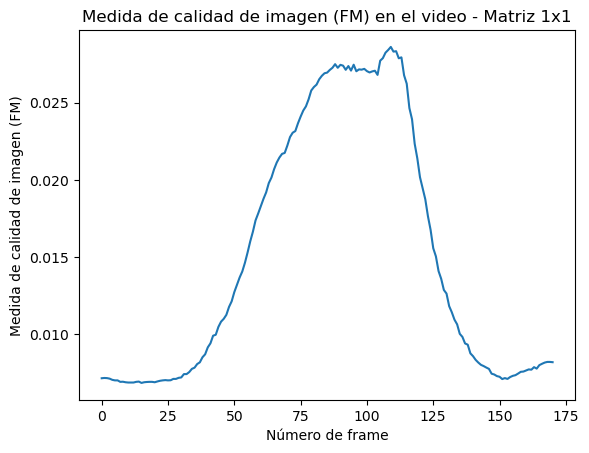

In [67]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 1, 1, porcentaje_area=1, UmbralFM=0.015)

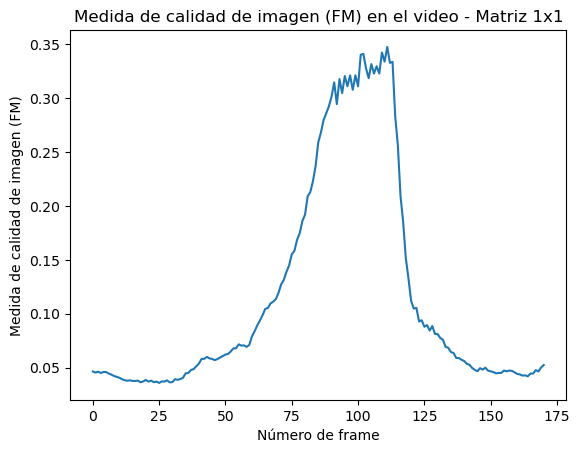

In [48]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 1, 1, porcentaje_area=0.10, UmbralFM=0.15)

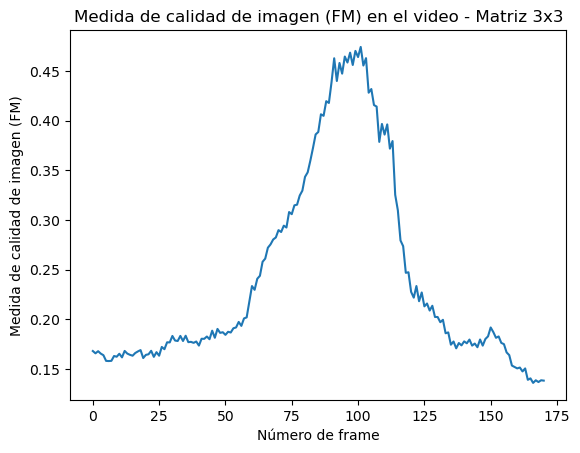

In [53]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 3, 3, porcentaje_area=0.10, UmbralFM=0.22)

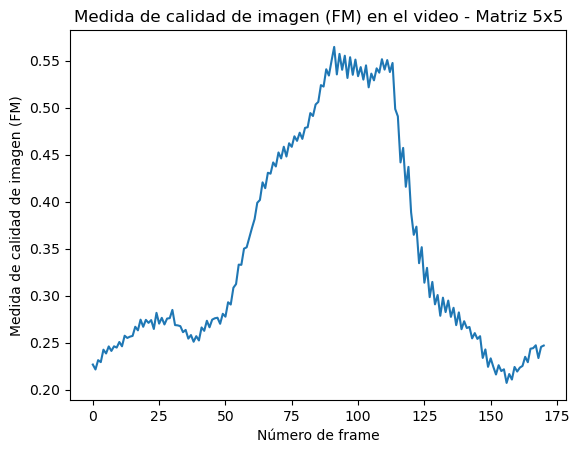

In [54]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 5, 5, porcentaje_area=0.10, UmbralFM=0.30)

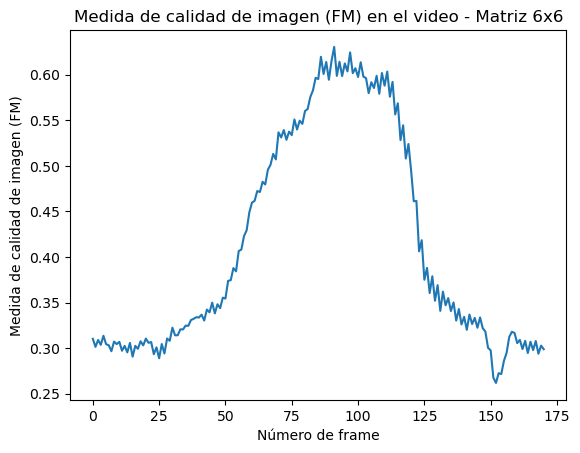

In [42]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 6, 6, porcentaje_area=0.10, UmbralFM=0.40)

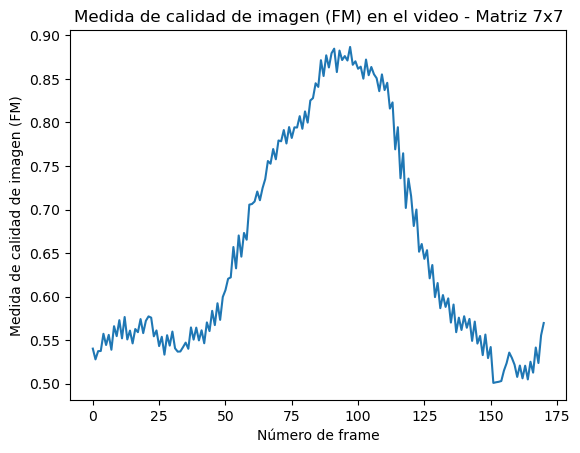

In [64]:
# Llamar a la función principal
analizar_calidad_video('focus_video.mov', 7, 7, porcentaje_area=0.05, UmbralFM=0.7)